In [35]:
import sys
sys.path.append("../")
sys.path.append("../..")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
import matplotlib.pylab as pylab
import matplotlib

from plot_params import params
from theory.units import *
from theory.spec_calc import PowerSpectra, PowerSpectraPopulations
from theory.astrometry_forecast import Parameter, AstrometryObservation, FisherForecast

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [37]:
pylab.rcParams.update(params)
plots_dir = "/Users/smsharma/Dropbox/Projects/LensPowerSpectra/LensPower/Draft/plots/"
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [38]:
pspec = PowerSpectra(precompute=['NFW', 'Burk'])

## Figure 5: Sensitivity to compact objects

In [6]:
def get_f_DM_lim(M_DM=1e8*M_s, R0_DM=0, sigma_mu = 1, sigma_alpha = None,
                 N_q_mu = 1e9, N_q_alpha = 1e9, 
                 l_min_mu=2, l_max_mu=2000, l_min_alpha=2, l_max_alpha=2, f_sky=1):
    
    l_max = max(l_max_mu, l_max_alpha)
    
    pspecpop = PowerSpectraPopulations(l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
        
    if sigma_mu is not None:
        Cl_ary = pspecpop.get_C_l_compact_total_ary()
    else:
        Cl_ary = np.zeros(len(Cl_ary)) 
    if sigma_alpha is not None:
        Cl_ary_accel = pspecpop.get_C_l_compact_total_ary(accel=True)
    else:
        Cl_ary_accel = np.zeros(len(Cl_ary)) 
            
    fDM_base = 0
    dfDM_base = 0.1
    

    Cl_ary_fid = np.array(Cl_ary)*fDM_base
    Cl_ary_accel_fid = np.array(Cl_ary_accel)*fDM_base

    p = np.array(Cl_ary)*(fDM_base + dfDM_base)
    m = np.array(Cl_ary)*(fDM_base - dfDM_base)

    p_a = np.array(Cl_ary_accel)*(fDM_base + dfDM_base)
    m_a = np.array(Cl_ary_accel)*(fDM_base - dfDM_base)

    fDM = Parameter('fDM', fDM_base ,dfDM_base ,None, True, p, m, 
                    p_a, m_a, l_min=1, l_max=l_max)

    parameters = [Cl_ary_fid, Cl_ary_accel_fid, 1, l_max, fDM]
    
    observation = AstrometryObservation(fsky=f_sky, sigma_mu=sigma_mu, sigma_alpha=sigma_alpha, 
                                        N_q_mu=N_q_mu, N_q_alpha=N_q_alpha, 
                                        l_min_mu=l_min_mu, l_max_mu=l_max_mu, l_min_alpha=l_min_alpha, l_max_alpha=l_max_alpha)
    
    
    
    fshr = FisherForecast(parameters, observation)
    lim = 1.64*np.sqrt(np.linalg.inv(fshr.fshr_cls + fshr.fshr_prior)[0,0])
    return lim, fshr.fshr_l

In [7]:
def get_f_DM_lim_simple(M_DM=1e8*M_s, R0_DM=0, sigma=1,
                 N_q = 1e8,
                 l_min=2, l_max=2000, f_sky=1,
                 accel=False,
                 l_los_min=1e-3 * pc, l_los_max=10 * kpc):
        
    pspecpop = PowerSpectraPopulations(l_min=l_min, l_max=l_max)
    pspecpop.set_radial_distribution(pspecpop.r2rho_V_NFW, R_min=1e-3*kpc, R_max=260*kpc)
    pspecpop.set_mass_distribution_compact(M_DM=M_DM, f_DM=1,R0_DM=R0_DM)
        
    Cl_ary = np.nan_to_num(pspecpop.get_C_l_compact_total_ary(accel=accel, l_los_min=l_los_min, l_los_max=l_los_max))
    
    Nl_ary = np.array(len(pspecpop.l_ary) * [4 * np.pi * sigma ** 2 / N_q])
        
    F = f_sky * (pspecpop.l_ary + 0.5) * (Cl_ary / (Nl_ary)) ** 2
    
    lim = 1.64 * np.sqrt(1/np.sum(F))
        
    return lim, F

In [8]:
1e12 / (4 * np.pi) / 1e10

7.957747154594768

In [9]:
# Maximum accessible multipoles

print(np.pi / np.sqrt(4 * np.pi / 1e8))
print(np.pi / np.sqrt(4 * np.pi / 1e12))
print(np.pi / np.sqrt(0.05 * 4 * np.pi / (1e12) ))
print(np.pi / np.sqrt(0.05 * 4 * np.pi / 1e10))

8862.26925452758
886226.925452758
3963327.297606011
396332.7297606011


In [10]:
print(np.pi / np.sqrt(0.05 * 4 * np.pi / 2e9))

177245.3850905516


In [31]:
2e9 / 0.05 / (4 *np.pi) / 1e9

3.183098861837907

In [32]:
2e9 / 0.05 / (4 *np.pi) / 1e9 * 4 *np.pi

40.0

In [33]:
1e12 / 50

20000000000.0

In [11]:
M_ary = np.logspace(-4.,9,100) * M_s
R_ary = np.logspace(-5,4.5,30) * pc

In [12]:
lim_ary = np.zeros((len(M_ary), len(R_ary)))
lim_ary_accel = np.zeros((len(M_ary), len(R_ary)))
lim_ary_gaia_accel = np.zeros((len(M_ary), len(R_ary)))

In [13]:
M_baseline = 1e2 * M_s

In [14]:
for iR, R in enumerate(tqdm_notebook(R_ary)):
    lim_temp = get_f_DM_lim_simple(M_baseline, R0_DM=R, sigma=0.1, N_q=1e11 * 4 * np.pi, l_min=50, l_max=500000, accel=True,f_sky = 0.05,
                                  l_los_min=1e-3 * pc, l_los_max=1 * kpc)[0]
    for iM, M in enumerate(M_ary):
        lim_ary_accel[iM, iR] = M_baseline / M * lim_temp

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


../theory/spec_calc.py:530: RuntimeWarning: divide by zero encountered in log10
  self.C_l_ary = 10 ** np.interp(np.log10(self.l_ary), np.log10(self.l_ary_calc), np.log10(self.C_l_calc_ary))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [48]:
for iR, R in enumerate(tqdm_notebook(R_ary)):
    lim_temp = get_f_DM_lim_simple(M_baseline, R0_DM=R, sigma=1, N_q=1e7 * 4 * np.pi, l_min=10, l_max=5000, accel=False,
                                  l_los_min=1e-3 * pc, l_los_max=100 * kpc)[0]
    for iM, M in enumerate(M_ary):
        lim_ary[iM, iR] = M_baseline / M * lim_temp

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


In [40]:
for iR, R in enumerate(tqdm_notebook(R_ary)):
    lim_temp = get_f_DM_lim_simple(M_baseline, R0_DM=R, sigma=2., N_q=5e9 * 4 * np.pi, l_min=50, l_max=50000, accel=True,f_sky = 0.05,
                                  l_los_min=1e-3 * pc, l_los_max=1 * kpc)[0]
    for iM, M in enumerate(M_ary):
        lim_ary_gaia_accel[iM, iR] = M_baseline / M * lim_temp

/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


../theory/spec_calc.py:530: RuntimeWarning: divide by zero encountered in log10
  self.C_l_ary = 10 ** np.interp(np.log10(self.l_ary), np.log10(self.l_ary_calc), np.log10(self.C_l_calc_ary))
/Users/smsharma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [47]:
5e9 * 4 *np.pi * 0.05

3141592653.589793

In [27]:
2e9  * (4 * np.pi / 0.05) / (4 * np.pi) / 1e10

4.0

In [49]:
lim_R = []
for iM, M in enumerate((M_ary)):
    lim_R.append(10 ** np.interp(0, np.log10(lim_ary[iM]), np.log10(R_ary)) / pc)

In [50]:
lim_R_accel = []
for iM, M in enumerate((M_ary)):
    lim_R_accel.append(10 ** np.interp(0, np.log10(lim_ary_accel[iM]), np.log10(R_ary)) / pc)

In [51]:
lim_R_gaia_accel = []
for iM, M in enumerate((M_ary)):
    lim_R_gaia_accel.append(10 ** np.interp(0, np.log10(lim_ary_gaia_accel[iM]), np.log10(R_ary)) / pc)

### Mass-extent plot

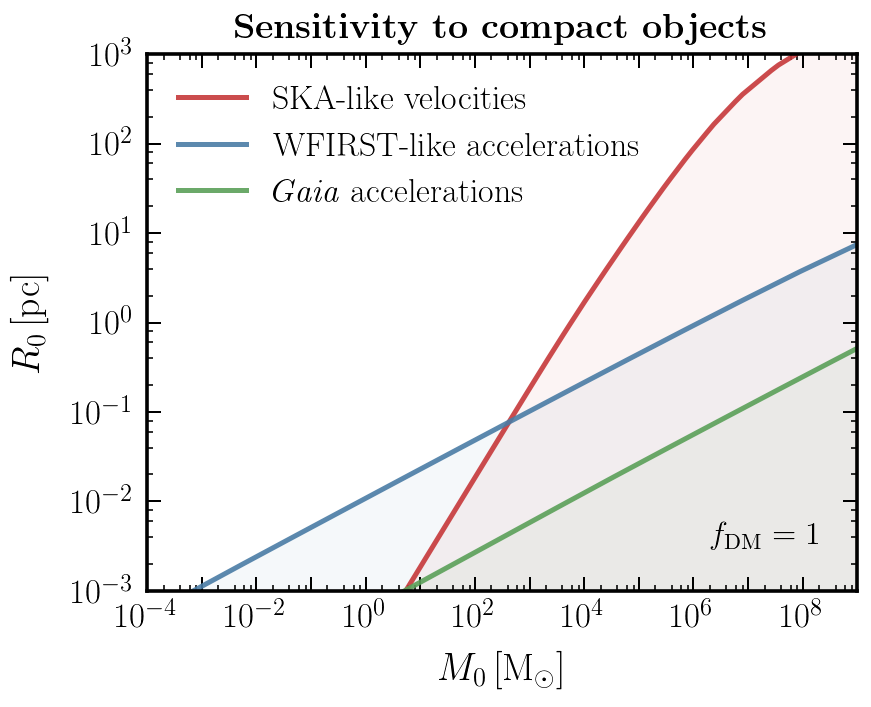

In [55]:
fig, ax = plt.subplots()

plt.plot(M_ary / M_s, np.array(lim_R), label="SKA-like velocities", color=cols_default[0])
plt.fill_between(M_ary / M_s, np.array(lim_R), 1e-4 * np.ones_like(lim_R), color=cols_default[0], alpha=0.05)

plt.plot(M_ary / M_s, np.array(lim_R_accel), label="WFIRST-like accelerations", color=cols_default[1])
plt.fill_between(M_ary / M_s, np.array(lim_R_accel), 1e-4 * np.ones_like(lim_R), color=cols_default[1], alpha=0.05)

plt.plot(M_ary / M_s, np.array(lim_R_gaia_accel), label="\emph{Gaia} accelerations", color=cols_default[2])
plt.fill_between(M_ary / M_s, np.array(lim_R_gaia_accel), 1e-4 * np.ones_like(lim_R_gaia_accel), color=cols_default[2], alpha=0.05)

plt.xscale("log")
plt.yscale("log")

plt.xlim(np.min(M_ary / M_s),np.max(M_ary / M_s))
plt.ylim(1e-3,1e3)

plt.xlabel("$M_0$\,[M$_\odot$]")
plt.ylabel("$R_0$\,[pc]")

plt.title('\\textbf{Sensitivity to compact objects}', y = 1.0, fontsize=18)

plt.tight_layout()
plt.text(2e6, 3e-3, "$f_\mathrm{DM} = 1$", fontsize=16)

# Tick tweaks 

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.xaxis.set_minor_locator(locmin)
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax.yaxis.set_minor_locator(locmin)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

every_nth = 2
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

plt.legend()

plt.tight_layout()
plt.savefig(plots_dir + "compact_M_vs_R.pdf")

### Density-mass plot

In [53]:
C = (4 / 3 * np.pi ** (3 / 2.))

M0 = lambda m22: 5e5 * M_s * C * m22 ** -3
R0 = lambda m22: 58 * pc * m22 ** -1

rho0 = M0(1) / (4 / 3 * np.pi * R0(1) ** 3)  / (M_s / pc ** 3)
m22_ary = np.logspace(-1,1,3)

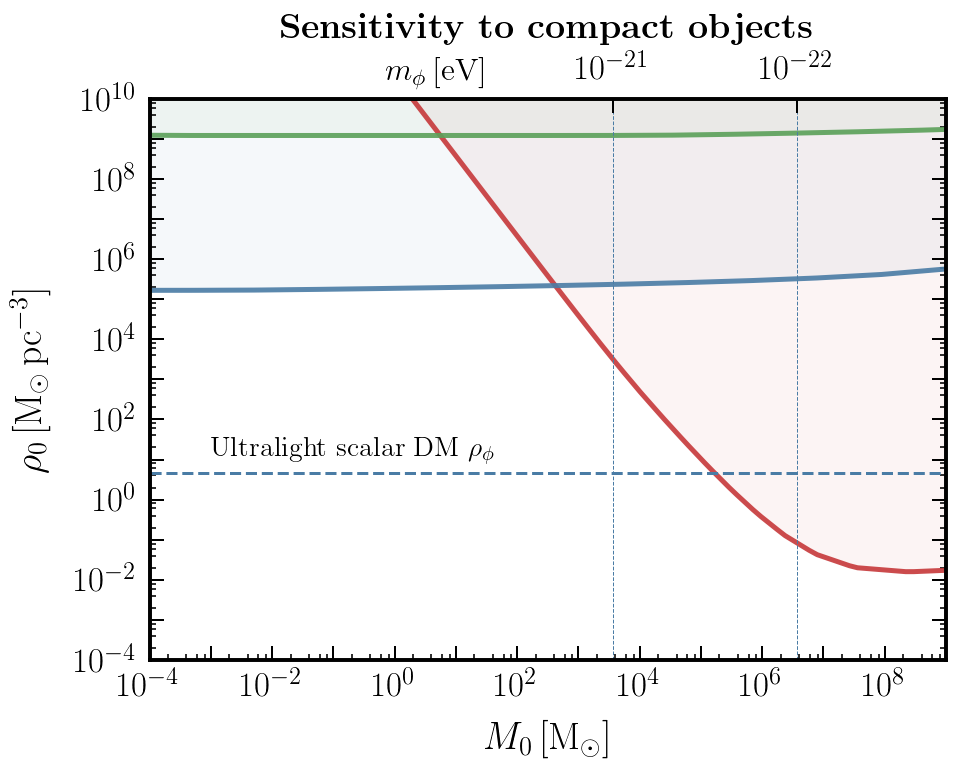

In [54]:
fig = plt.figure(figsize=[6.153846153846153 * 1.1, 5.0 * 1.1])
ax1 = fig.add_subplot(111)


ax1.plot(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R) * pc) ** 3) / (M_s / pc ** 3), label="SKA velocities", color=cols_default[0])
ax1.fill_between(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R) * pc) ** 3) / (M_s / pc ** 3), 1e20 * np.ones_like(M_ary/M_s), color=cols_default[0], alpha=0.05)

ax1.plot(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R_accel) * pc) ** 3) / (M_s / pc ** 3), label="WFIRST-like accelerations", color=cols_default[1])
ax1.fill_between(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R_accel) * pc) ** 3) / (M_s / pc ** 3), 1e20 * np.ones_like(M_ary/M_s), color=cols_default[1], alpha=0.05)

ax1.plot(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R_gaia_accel) * pc) ** 3) / (M_s / pc ** 3), label="\emph{Gaia} accelerations", color=cols_default[2])
ax1.fill_between(M_ary/M_s, M_ary / (4 / 3. * np.pi * (np.array(lim_R_gaia_accel) * pc) ** 3) / (M_s / pc ** 3), 1e20 * np.ones_like(M_ary/M_s), color=cols_default[2], alpha=0.05)

ax1.set_xscale("log")
ax1.set_yscale("log")

ax1.set_xlim(np.min(M_ary / M_s),np.max(M_ary / M_s))
ax1.set_ylim(1e-4, 1e10)

ax1.set_title('\\textbf{Sensitivity to compact objects}', y = 1.08, fontsize=18)
ax1.set_xlabel("$M_0$\,[M$_\odot$]")
ax1.set_ylabel("$\\rho_0$\,[M$_\odot$\,pc$^{-3}$]")

ax1.axhline(rho0, ls='--', lw=1.5, color=cols_default[1])
for m22 in m22_ary:
    ax1.axvline(M0(m22) / M_s, ls='--', lw=0.5, color=cols_default[1])
    
def latex_float(f):
    float_str = "{0:.2g}".format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        if base is "1":
            return r"$10^{{{1}}}$".format(base, int(exponent))
        else:
            return r"${0} \times 10^{{{1}}}$".format(base, int(exponent))
    else:
        return float_str

ax2 = ax1.twiny()

ax2.set_xscale("log")
ax2.set_yscale("log")

ax2.set_xticks(list(M0(m22_ary) / M_s))
ax2.set_xticklabels([latex_float(m22  * 1e-22) for m22 in m22_ary])
ax2.set_xlim(ax1.get_xbound())
ax2.text(0.7, 10 ** 10.35, "$m_\phi\,[\mathrm{eV}]$", fontsize=16)
ax2.text(1e-3, rho0 + 5, r"Ultralight scalar DM $\rho_\phi$", fontsize=14)
# ax2.set_xlabel("$m_\phi\,[\mathrm{eV}]$")
# ax1.legend()

# Tick tweaks 

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=12) 
ax1.xaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=12)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

locmaj = matplotlib.ticker.LogLocator(base=10,numticks=15) 
ax1.yaxis.set_major_locator(locmaj)

locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=14)
ax1.yaxis.set_minor_locator(locmin)
ax1.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())


every_nth = 2
for n, label in enumerate(ax1.xaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

for n, label in enumerate(ax1.yaxis.get_ticklabels()):
    if n % every_nth != 1:
        label.set_visible(False)

plt.tight_layout()
plt.savefig(plots_dir + "compact_M_vs_rho.pdf")